## Загрузка данных

In [ ]:
!pip install gdown

### Загрузка картинок

In [ ]:
!gdown https://drive.google.com/uc?id=1Usn-XgKql3aUAQcbt5S4-BEM7Zg8Jgwq
!unzip -qq AllRecipes_images.zip
!rm AllRecipes_images.zip

Downloading...
From: https://drive.google.com/uc?id=1Usn-XgKql3aUAQcbt5S4-BEM7Zg8Jgwq
To: /content/AllRecipes_images.zip
4.02GB [00:56, 71.7MB/s]


### Загрузка ингредиентов блюд

In [ ]:
!gdown https://drive.google.com/uc?id=11gUIVJrOmdc0edYF9eHT11DrhYFnuxM2
!gdown https://drive.google.com/uc?id=1Oj-tq8L0mU34kjIo7DWjG9uxeXZPMrkP
!gdown https://drive.google.com/uc?id=1M7ZLpVn0-E1X1HJhPERwwwphlQ3mtOGQ

Downloading...
From: https://drive.google.com/uc?id=11gUIVJrOmdc0edYF9eHT11DrhYFnuxM2
To: /content/clean_ingred.txt
100% 1.44k/1.44k [00:00<00:00, 2.70MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Oj-tq8L0mU34kjIo7DWjG9uxeXZPMrkP
To: /content/rus_clean_ingred.txt
100% 2.88k/2.88k [00:00<00:00, 5.28MB/s]
Downloading...
From: https://drive.google.com/uc?id=1M7ZLpVn0-E1X1HJhPERwwwphlQ3mtOGQ
To: /content/recipes.json
6.27MB [00:00, 20.0MB/s]


## Обучение

In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import numpy as np
from tqdm.notebook import tqdm
from torch.optim import lr_scheduler
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
with open('recipes.json', 'rb') as f:
  recipe_list = json.loads(f.read())
with open('clean_ingred.txt', 'r') as f:
  clean_ingredients = list(f.read().split('\n'))

In [ ]:
en2ru = {}
with open('clean_ingred.txt', 'r') as f:
  en=f.readlines()
with open('rus_clean_ingred.txt', 'r') as f:
  ru=f.readlines()

for e, r in zip(en, ru):
  en2ru[e.rstrip('\n')] = r.rstrip('\n')
with open('en2ru_ing.json', 'w') as f:
  json.dump(en2ru, f)

In [ ]:
id2word = defaultdict()
for i, ingr in enumerate(clean_ingredients):
  id2word[i+1] = ingr

word2id = {v:k for k,v in id2word.items()}
def words2ids(ingreds):
  return [word2id[ing] for ing in ingreds]

In [ ]:
class RecipesDataset(Dataset):
  def __init__(self, recipes_json, img_folder, transform=None):
    super().__init__()

    with open(recipes_json, 'r') as f:
      recipes = json.load(f)
    self.recipes = defaultdict(dict)
    for recipe in recipes:
      self.recipes[recipe['id']] = recipe

    self.img_folder = img_folder
    self.imgs = os.listdir(self.img_folder)
    self.imgs = [img for img in self.imgs if img.split('_')[0] in self.recipes]
    
    self.transform = transform

  def __getitem__(self, index):
    img_name = self.imgs[index]
    img = Image.open(self.img_folder + img_name).convert('RGB')
    if self.transform is not None:
      img = self.transform(img)
    
    recipe_id = img_name.split('_')[0]
    ingred_list = self.recipes[recipe_id]['ingred_list']
    return img, torch.LongTensor(words2ids(ingred_list))

  def __len__(self):
    return len(self.imgs)

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def pad_collate(data):
  # отсортируем по длине описания
  data.sort(key=lambda x: len(x[1]), reverse=True)
  images, captions = zip(*data)
  
  # составим 4D тензор изображений из кортежа 3D тензоров
  # images: (batch_size, channels(rgb), width, height)
  images = torch.stack(images, 0)
  
  # составим 2D тензор описаний из кортежа 1D тензоров
  # дополним каждое описание символом <pad> так, чтобы у всех описаний совпадали длины
  targets = pad_sequence(captions, batch_first=True, padding_value=0)

  return images, targets

In [ ]:
!pip install googletrans
from random import randint
from googletrans import Translator
translator = Translator()

val_images = os.listdir('AllRecipes_images/val')

def predict_val_image():
  with torch.no_grad():
    img_name = val_images[randint(0, len(val_images)-1)]
    recipe_id = img_name.split('_')[0]
    img = Image.open(os.path.join('AllRecipes_images/val', img_name))
    plt.figure(figsize=(12,8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    img = transform_val(img).to(device).unsqueeze(0)
    ingred_pred = model(img) > 0.25
    ingred_pred = ingred_pred.nonzero()[:, 1].tolist()
    ingred_pred = [id2word[ing+1] for ing in ingred_pred]
    ingred_pred = [en2ru[ing] for ing in ingred_pred]
    
    dish_name = train_data.recipes[recipe_id]['item_name']
    #dish_name = translator.translate(dish_name, src='en', dest='ru').text
    ingred_real = train_data.recipes[recipe_id]['ingred_list']
    ingred_real = [en2ru[ing] for ing in ingred_real]
    print(dish_name + ':', end='\n\n')
    print('Real:')
    print('\t' + '\n\t'.join(ingred_real), end='\n\n')
    print('Prediction:')
    print('\t' + '\n\t'.join(ingred_pred))

In [ ]:
def update_error_types(error_types, y_pred, y_true):
  y_pred, y_true = y_pred.cpu().numpy(), y_true.cpu().numpy()

  error_types['tp_all'] += (y_pred * y_true).sum()
  error_types['fp_all'] += (y_pred * (1-y_true)).sum()
  error_types['fn_all'] += ((1-y_pred) * y_true).sum()

In [ ]:
import torch.nn.functional as F
def label2onehot(labels):
    # input labels to one hot vector
    return F.one_hot(labels, num_classes=len(word2id)+1).sum(1)[:, 1:]

def compute_metrics(error_types, eps=1e-10, weights=None):
  result = defaultdict(float)
  result['jaccard'] = error_types['tp_all'] / (error_types['tp_all'] + error_types['fp_all'] + error_types['fn_all'] + eps)

  pre = error_types['tp_all'] / (error_types['tp_all'] + error_types['fp_all'] + eps)
  result['pre'] = pre
  rec = error_types['tp_all'] / (error_types['tp_all'] + error_types['fn_all'] + eps)
  result['rec'] = rec
  f1 = 2 * (pre * rec) / (pre + rec + eps)
  result['f1'] = f1
  return result

In [ ]:
def train(model, criterion, optimizer, scheduler, num_epochs,
          epoch_losses, start_epoch, save_path):
 
  for epoch in range(start_epoch, num_epochs + start_epoch):
    # режим обучения
    model.train()

    running_loss = 0.0
    print(f'Эпоха {epoch}/{start_epoch + num_epochs - 1}')
    for images, tokens in tqdm(train_loader, desc=f'Обучение {epoch}'):
      # Перенесем изобр-я и описания на GPU, составим вектор истинных описаний
      images = images.to(device)
      real = label2onehot(tokens).to(device).float()

      # Проведем изобр-я через модель, получим описания (в виде векторов id), сгенерир. моделью
      pred = model(images)
      
      # обнулить градиенты
      optimizer.zero_grad()

      # посчитать лосс на батче
      loss = criterion(pred, real)
      
      # посчитать градиенты
      loss.backward()
      
      # обновить параметры модели
      optimizer.step()

      # обновить лосс
      running_loss += loss.item()


    train_loss = running_loss / len(train_loader)
    epoch_losses['train_nll'].append(train_loss)

    torch.save(model.state_dict(), f'/content/drive/My Drive/Dish-id/model_densenet/epoch_{epoch}.pth')

    with open(f'{save_path}/epoch_losses.pkl', 'wb') as f:
      pickle.dump(epoch_losses, f)

    # Validation
    error_types = {'tp_all': 0, 'fp_all': 0, 'fn_all': 0}
    model.eval()
    for images, tokens in tqdm(val_loader, desc=f'Валидация'):
      images = images.to(device)
      real = label2onehot(tokens).to(device)

      pred = model(images) > 0.25
      update_error_types(error_types, real, pred)

    val_metrics = compute_metrics(error_types)
    
    predict_val_image()

    print(f'Train loss:\t{train_loss:.4f}')
    print(f'Val metrics:\n\t', end='')
    for k, v in val_metrics.items():
      print(f'{k}: {v:.4f}', end=', ')
      epoch_losses[k].append(v)

    scheduler.step(epoch_losses['jaccard'][-1])
    
    print('\n')

In [ ]:
transform_train = transforms.Compose([
  transforms.RandomResizedCrop((224, 224)),
  transforms.RandomHorizontalFlip(0.5),
  transforms.ToTensor(),
  transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

train_data = RecipesDataset('recipes.json', 'AllRecipes_images/train/', transform_train)

batch_size = 128
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          num_workers=4, collate_fn=pad_collate, shuffle=True)

In [ ]:
transform_val = transforms.Compose([
  transforms.Resize((250, 250)),
  transforms.CenterCrop((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

val_data = RecipesDataset('recipes.json', 'AllRecipes_images/val/', transform_val)

batch_size = 128
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          num_workers=4, collate_fn=pad_collate, shuffle=False)

Модель

In [ ]:
%%capture
model = models.densenet161(pretrained=True)
for param in model.parameters():
  param.requires_grad = False
num_feat = model.classifier.in_features
model.classifier = nn.Sequential(
        nn.Linear(num_feat, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, len(word2id)),
        nn.Sigmoid()
    )
model.to(device)

In [ ]:
model.load_state_dict(torch.load('/content/drive/My Drive/Dish-id/model_densenet/epoch_22.pth'))

with open('/content/drive/My Drive/Dish-id/model_densenet/epoch_losses.pkl', 'rb') as f:
  epoch_losses = pickle.load(f)
for k,v in epoch_losses.items():
  epoch_losses[k] = v[:22]

In [ ]:
#epoch_losses = defaultdict(list)

In [ ]:
for param in model.features.denseblock4.parameters():
  param.requires_grad = True

In [ ]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          num_workers=4, collate_fn=pad_collate, shuffle=True)
batch_size = 128
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          num_workers=4, collate_fn=pad_collate, shuffle=False)

In [ ]:
criterion = nn.BCELoss(reduction='mean')
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True, min_lr=1e-5)

Эпоха 1/5


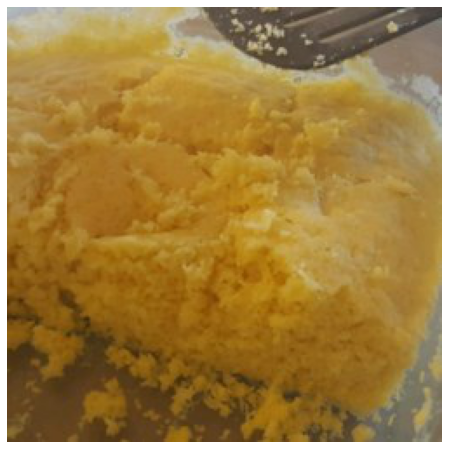

5 Minute Microwave Cornbread:

Real:
	сахар
	молоко
	масло
	мука
	разрыхлитель
	яйцо
	кукурузная мука

Prediction:
	мука
	молоко
	яйцо
	сливочное масло
	сахар
Train loss:	0.0928
Val metrics:
	jaccard: 0.3077, pre: 0.4896, rec: 0.4531, f1: 0.4706, 

Эпоха 2/5


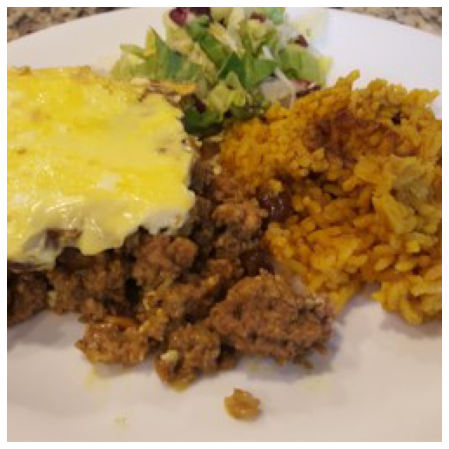

Best Bobotie:

Real:
	варенье
	масло
	лук
	молоко
	говядина
	изюм
	яйцо
	хлеб

Prediction:
	говядина
	фасоль
	лук
	помидор
	сахар
	вода
	соус
	масло
Train loss:	0.0846
Val metrics:
	jaccard: 0.3206, pre: 0.4987, rec: 0.4730, f1: 0.4855, 

Эпоха 3/5


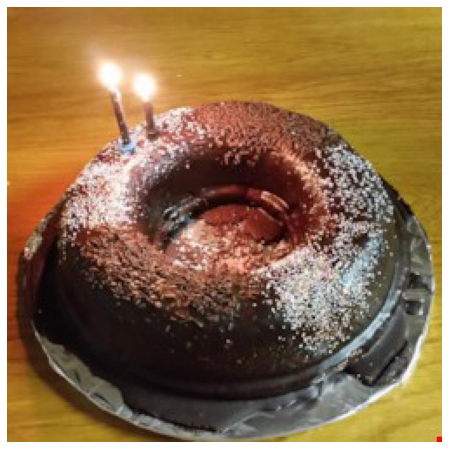

Buttermilk Chocolate Cake with Fudge Icing:

Real:
	сахар
	масло
	ваниль
	вода
	молоко
	сливочное масло
	кефир
	мука
	какао
	яйцо
	пищевая сода

Prediction:
	мука
	молоко
	разрыхлитель
	ваниль
	яйцо
	сливочное масло
	сахар
	вода
	какао
	масло
	смесь для кекса
	смесь для пуддинга
	пищевая сода
Train loss:	0.0823
Val metrics:
	jaccard: 0.3262, pre: 0.5201, rec: 0.4666, f1: 0.4919, 

Эпоха 4/5


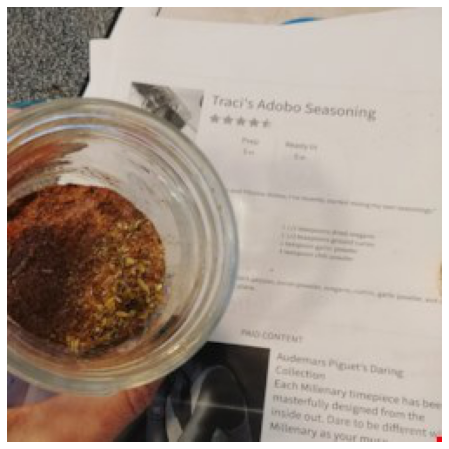

Traci's Adobo Seasoning:

Real:
	паприка
	лук

Prediction:
	тимьян
	паприка
	лук
	сахар
	масло
Train loss:	0.0807
Val metrics:
	jaccard: 0.3325, pre: 0.5292, rec: 0.4720, f1: 0.4990, 

Эпоха 5/5


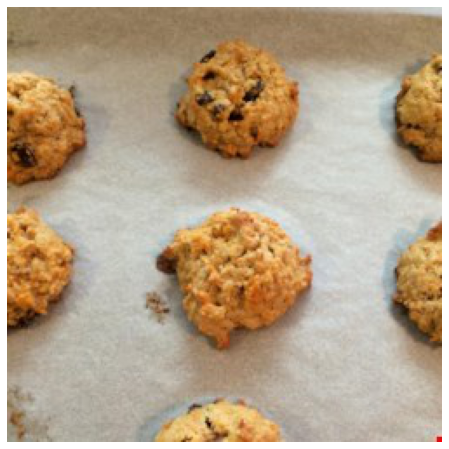

Peanut Butter Carrot Cookies:

Real:
	сахар
	чипсы
	овсяные хлопья
	молоко
	сливочное масло
	морковь
	мука
	арахисовое масло
	яйцо
	пищевая сода

Prediction:
	мука
	разрыхлитель
	ваниль
	корица
	яйцо
	сливочное масло
	сахар
	чипсы
	овсяные хлопья
	изюм
	грецкий орех
	арахисовое масло
	пищевая сода
Train loss:	0.0793
Val metrics:
	jaccard: 0.3364, pre: 0.5433, rec: 0.4691, f1: 0.5035, 



In [ ]:
torch.backends.cudnn.benchmark = True
train(model, criterion, optimizer, scheduler, num_epochs=5, epoch_losses=epoch_losses, 
      start_epoch=1, save_path='/content/drive/My Drive/Dish-id/model_densenet')

In [ ]:
for param in model.features.transition3.parameters():
  param.requires_grad = True
for param in model.features.denseblock3.parameters():
  param.requires_grad = True

In [ ]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True, min_lr=1e-5)

In [ ]:
torch.backends.cudnn.benchmark = True
train(model, criterion, optimizer, scheduler, num_epochs=5, epoch_losses=epoch_losses, 
      start_epoch=11, save_path='/content/drive/My Drive/Dish-id/model_densenet')

Эпоха 16/20


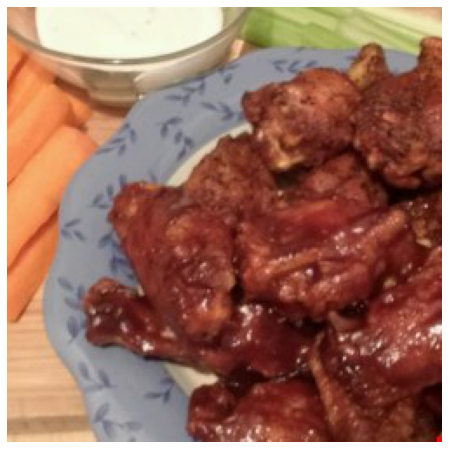

New Year's Eve Chicken Wings:

Real:
	сыр
	сельдерей
	масло
	морковь
	курица
	соус

Prediction:
	курица
	лук
	хлеб
	яйцо
	сахар
	вода
	соус
Train loss:	0.0701
Val metrics:
	jaccard: 0.3578, pre: 0.5749, rec: 0.4865, f1: 0.5270, 

Эпоха 17/20


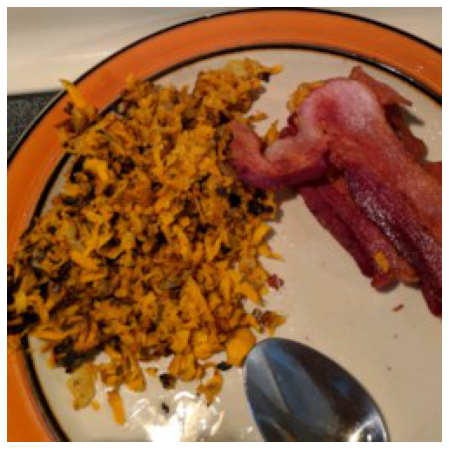

Sweet Potato Hash Browns:

Real:
	картофель
	зеленый лук
	масло
	лук
	тимьян
	бекон

Prediction:
	бекон
	лук
	рис
	масло
Train loss:	0.0693
Val metrics:
	jaccard: 0.3608, pre: 0.5785, rec: 0.4895, f1: 0.5303, 

Эпоха 18/20


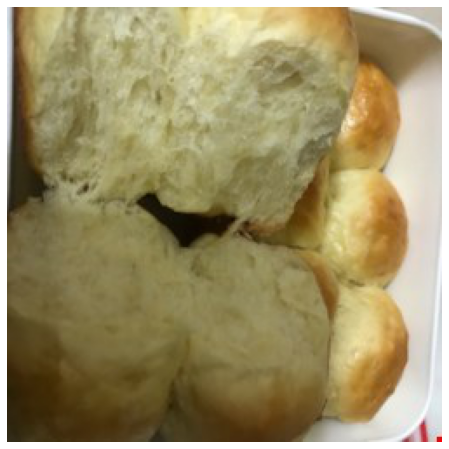

Portuguese Sweet Bread I:

Real:
	сахар
	маргарин
	молоко
	мука
	яйцо

Prediction:
	мука
	молоко
	сливочное масло
	сахар
	вода
	масло
Train loss:	0.0685
Val metrics:
	jaccard: 0.3593, pre: 0.5897, rec: 0.4790, f1: 0.5286, 

Эпоха 19/20


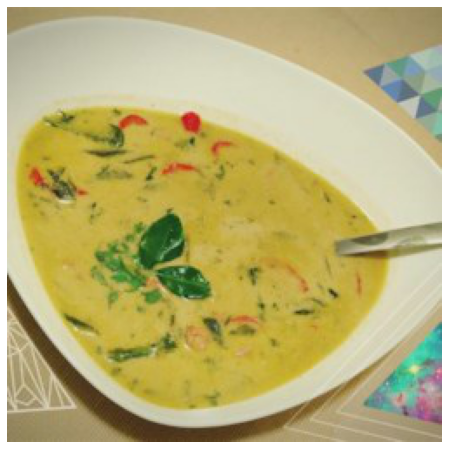

Thai Green Curry Prawns:

Real:
	масло
	кукуруза
	молоко
	креветка
	стручковая фасоль
	имбирь
	лайм
	лимон
	соевый соус

Prediction:
	курица
	красный перец
	молоко
	лук
	сливочное масло
	сахар
	вода
	соус
	сок
	масло
	морковь
	соевый соус
	имбирь
Train loss:	0.0677
Val metrics:
	jaccard: 0.3590, pre: 0.5791, rec: 0.4857, f1: 0.5283, 

Эпоха 20/20


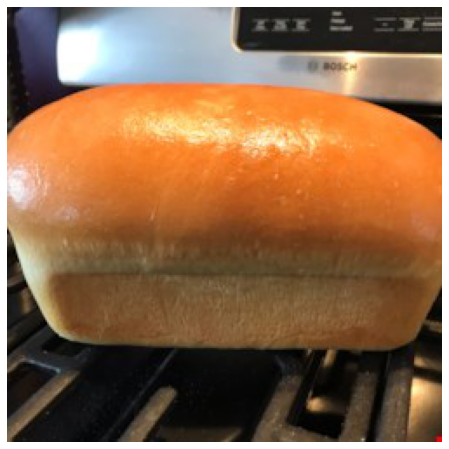

Simple White Bread:

Real:
	сахар
	молоко
	масло
	вода
	сливочное масло
	мука

Prediction:
	мука
	молоко
	сахар
	вода
	масло
	кокосовое масло
Train loss:	0.0670
Val metrics:
	jaccard: 0.3584, pre: 0.5774, rec: 0.4858, f1: 0.5276, 



In [ ]:
torch.backends.cudnn.benchmark = True
train(model, criterion, optimizer, scheduler, num_epochs=5, epoch_losses=epoch_losses, 
      start_epoch=16, save_path='/content/drive/My Drive/Dish-id/model_densenet')

In [ ]:
criterion = nn.BCELoss(reduction='mean')
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=1, verbose=True, min_lr=1e-5)

Эпоха 22/22


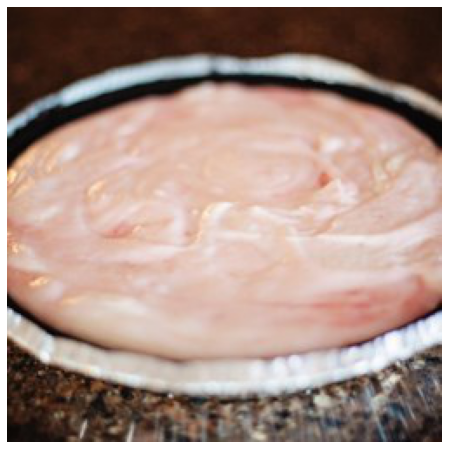

Peppermint Party Pie:

Real:
	молоко
	сливочное масло
	взбитые сливки
	печенье
	конфеты

Prediction:
	сахар
	вода
Train loss:	0.0617
Val metrics:
	jaccard: 0.3695, pre: 0.5858, rec: 0.5002, f1: 0.5396, 



In [ ]:
torch.backends.cudnn.benchmark = True
train(model, criterion, optimizer, scheduler, num_epochs=1, epoch_losses=epoch_losses, 
      start_epoch=22, save_path='/content/drive/My Drive/Dish-id/model_densenet')

In [ ]:
for param in model.features.denseblock4.parameters():
  param.requires_grad = False
for param in model.features.transition3.parameters():
  param.requires_grad = False
for param in model.features.denseblock3.parameters():
  param.requires_grad = False

In [ ]:
criterion = nn.BCELoss(reduction='mean')
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True, min_lr=1e-5)

Эпоха 23/25


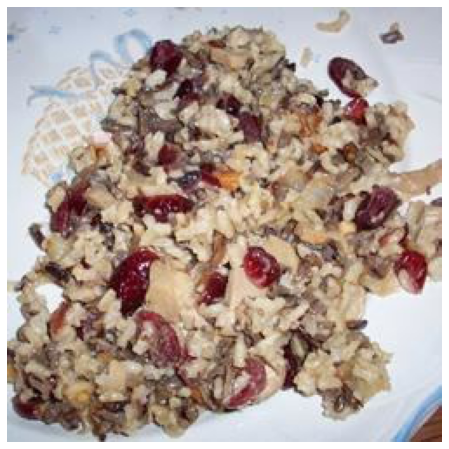

Harvest Rice Dish:

Real:
	сахар
	грибы
	миндаль
	лук
	сливочное масло
	курица
	апельсин
	клюква
	рис

Prediction:
	курица
	клюква
	лук
	миндаль
	сливочное масло
	сахар
	рис
	апельсин
	изюм
	грецкий орех
	кешью
	пекан
Train loss:	0.0610
Val metrics:
	jaccard: 0.3691, pre: 0.5868, rec: 0.4987, f1: 0.5392, 

Эпоха 24/25


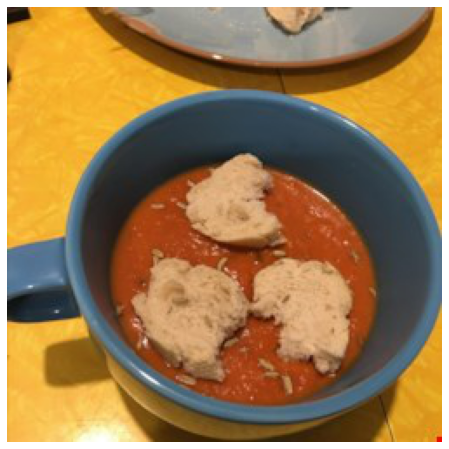

Instant Pot® Tomato Soup:

Real:
	сыр
	сахар
	красный перец
	сельдерей
	масло
	лук
	сливочное масло
	молоко
	морковь
	мука
	овощи
	помидор

Prediction:
	курица
	паприка
	мука
	молоко
	лук
	сливочное масло
	вода
	соус
	масло
Train loss:	0.0607
Val metrics:
	jaccard: 0.3681, pre: 0.5863, rec: 0.4973, f1: 0.5381, 

Эпоха 25/25


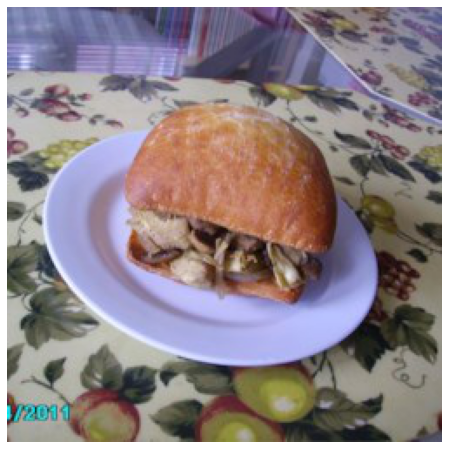

Mushroom Artichoke Sandwich:

Real:
	грибы
	сыр
	масло
	лук
	вода

Prediction:
	лук
	сыр
	соус
Train loss:	0.0606
Val metrics:
	jaccard: 0.3682, pre: 0.5869, rec: 0.4969, f1: 0.5382, 



In [ ]:
torch.backends.cudnn.benchmark = True
train(model, criterion, optimizer, scheduler, num_epochs=3, epoch_losses=epoch_losses, 
      start_epoch=23, save_path='/content/drive/My Drive/Dish-id/model_densenet')

Эпоха 26/30


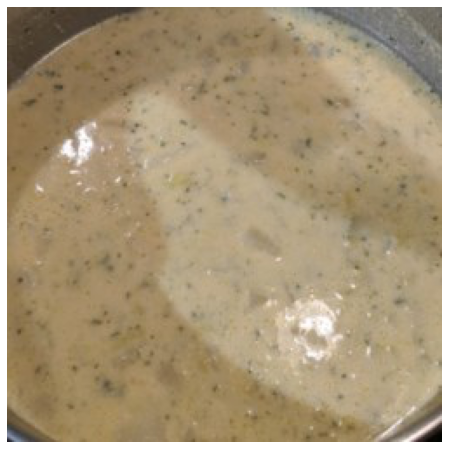

Winter Leek and Potato Soup:

Real:
	лук-порей
	сыр
	картофель
	лук
	сливочное масло
	курица

Prediction:
	курица
	мука
	молоко
	лук
	сыр
	картофель
	сливочное масло
	брокколи
	взбитые сливки
Train loss:	0.0605
Val metrics:
	jaccard: 0.3679, pre: 0.5857, rec: 0.4973, f1: 0.5379, Epoch     4: reducing learning rate of group 0 to 5.0000e-05.


Эпоха 27/30


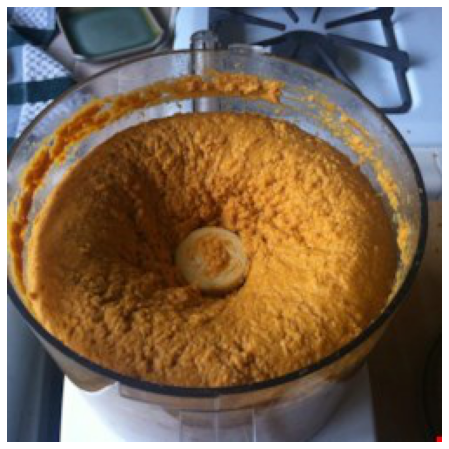

Pumpkin Hummus:

Real:
	тыква
	сок
	масло
	корица
	фасоль

Prediction:
	фасоль
	сахар
	сок
	масло
Train loss:	0.0602
Val metrics:
	jaccard: 0.3677, pre: 0.5851, rec: 0.4974, f1: 0.5377, 

Эпоха 28/30


KeyboardInterrupt: ignored

In [ ]:
torch.backends.cudnn.benchmark = True
train(model, criterion, optimizer, scheduler, num_epochs=5, epoch_losses=epoch_losses, 
      start_epoch=26, save_path='/content/drive/My Drive/Dish-id/model_densenet')

Graphs

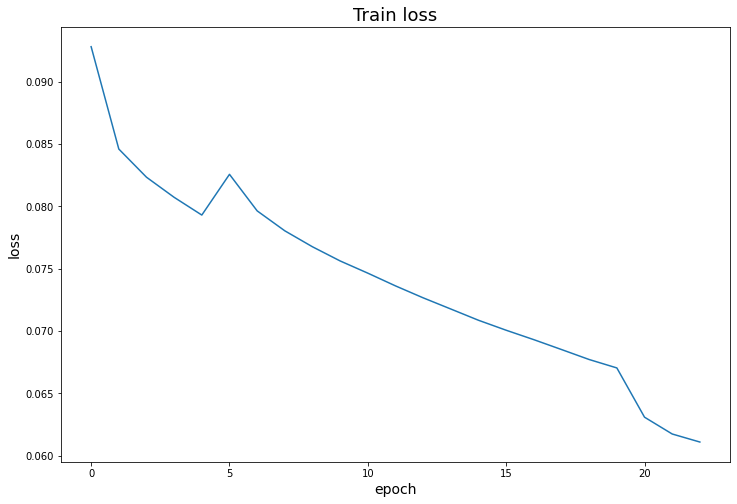

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(epoch_losses['train_nll'])
plt.title('Train loss', fontsize=18)
plt.ylabel('loss', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.show()

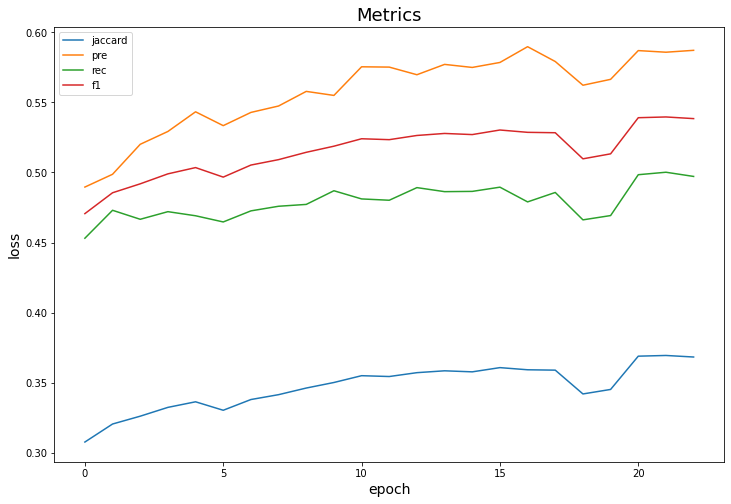

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Metrics', fontsize=18)
for k in epoch_losses:
  if k=='train_nll':
    continue
  plt.plot(epoch_losses[k], label=k)

plt.ylabel('loss', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.legend()
plt.yscale('linear')
plt.show()